##  Load Libraries and Data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose

# Set plot style for better aesthetics
sns.set_style("whitegrid")

# Load the final model-ready dataset from Phase 1
df = pd.read_csv('model_ready_dataset.csv', parse_dates=['date'], index_col='date')

print("Dataset loaded successfully. Shape:", df.shape)

Dataset loaded successfully. Shape: (162, 110)


## Time-Series Decomposition

--- Plotting Time-Series Decomposition ---


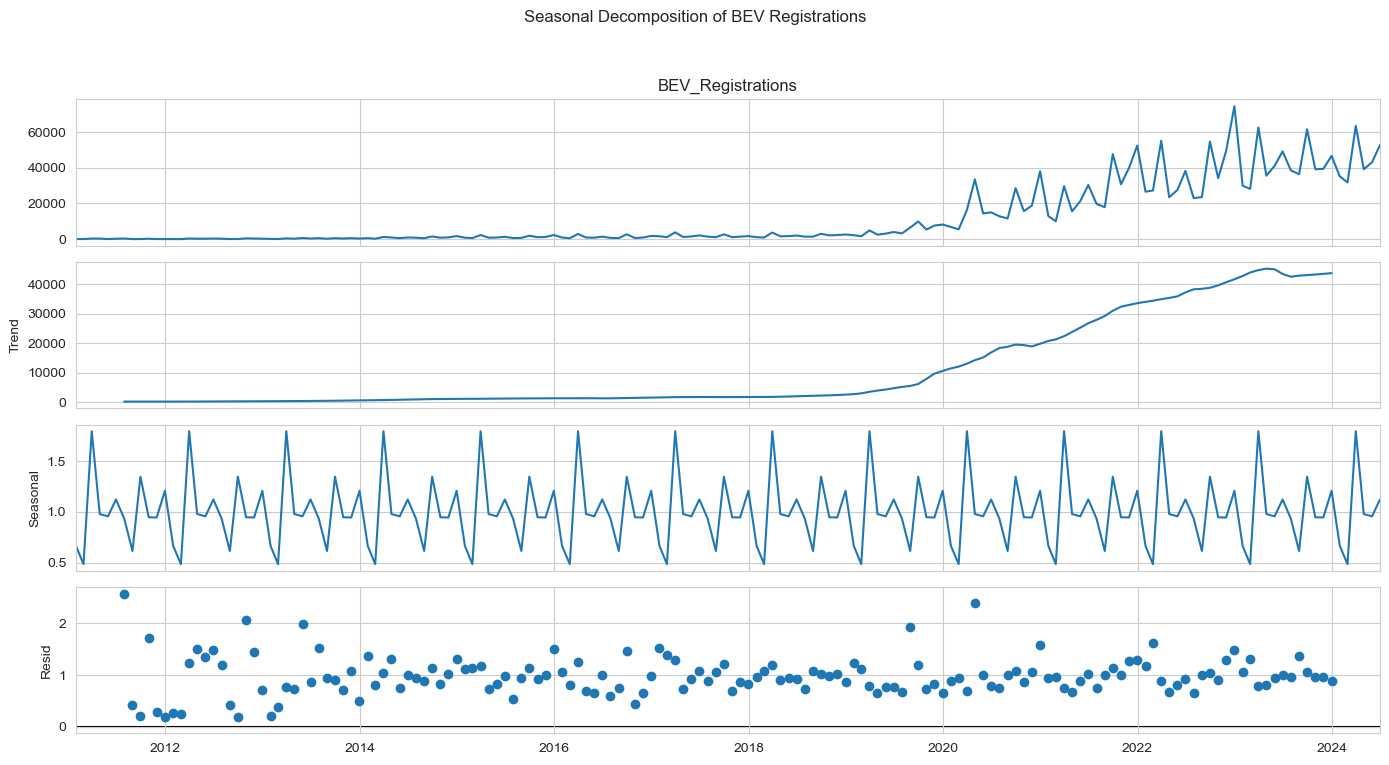

In [2]:
# Performing multiplicative seasonal decomposition since the seasonal variation appears to grow with the trend
decomposition = seasonal_decompose(df['BEV_Registrations'], model='multiplicative', period=12)

# Plotting the decomposed components
print("--- Plotting Time-Series Decomposition ---")
fig = decomposition.plot()
# figure size for better readability
fig.set_size_inches(14, 8)
# Add the main title
fig.suptitle('Seasonal Decomposition of BEV Registrations')

# The 'rect' argument leaves space at the top of the figure for the suptitle.
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()


The decomposition plot clearly shows a powerful upward trend. The seasonality plot confirms the strong bi-annual pattern, peaking around March (month 3) and September (month 9). The residuals show periods of higher-than-usual volatility, particularly around 2020, likely corresponding to the COVID-19 pandemic.

## S-Curve and Growth Analysis
The long term adoption curve


--- Plotting Cumulative Adoption (S-Curve) ---


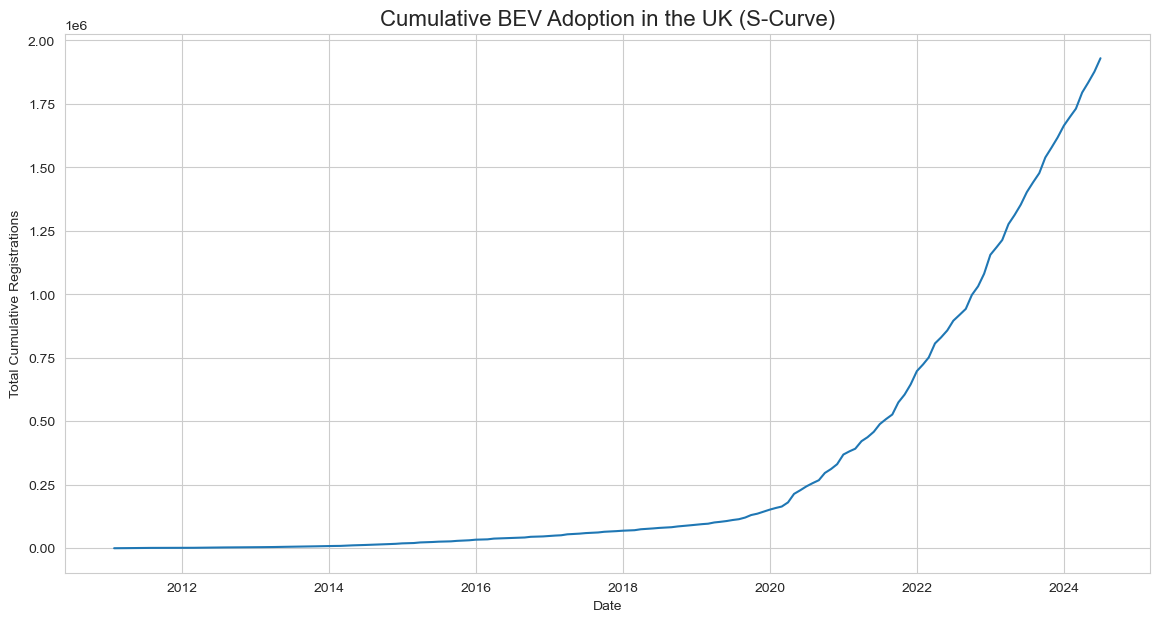


--- Plotting Monthly BEV Growth Rate ---


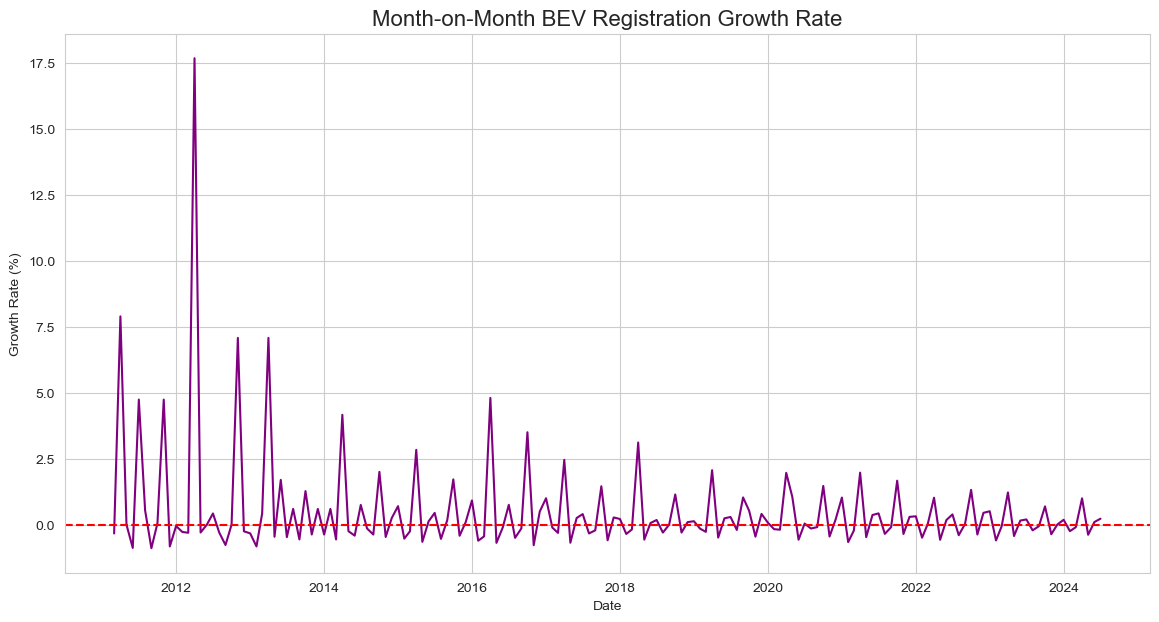

In [3]:
# --- Plot 1: Cumulative Adoption S-Curve ---
print("\n--- Plotting Cumulative Adoption (S-Curve) ---")
plt.figure(figsize=(14, 7))
ax = sns.lineplot(x=df.index, y=df['cumulative_bev'])
ax.set_title('Cumulative BEV Adoption in the UK (S-Curve)', fontsize=16)
ax.set_ylabel('Total Cumulative Registrations')
ax.set_xlabel('Date')
plt.show()


# --- Plot 2: Monthly Growth Rate ---
print("\n--- Plotting Monthly BEV Growth Rate ---")
plt.figure(figsize=(14, 7))
ax = sns.lineplot(x=df.index, y=df['bev_growth_rate'], color='purple')
ax.set_title('Month-on-Month BEV Registration Growth Rate', fontsize=16)
ax.set_ylabel('Growth Rate (%)')
ax.set_xlabel('Date')
plt.axhline(0, color='red', linestyle='--') # reference line
plt.show()

1. The cumulative plot shows a classic "S-curve" shape, currently in a steep acceleration phase. 
2. The growth rate plot highlights the high volatility of the market, especially in the early years, and shows how growth is influenced by the seasonal sales cycle.
3. The diminishing growth rate of BEV registrations clearly show that market is moving from the early adopters stage to early majority stage after the EVs have been widely accepted by UK, which is also depicted from the steep curve of BEV adoption.

## Correlation Analysis


--- Plotting Correlation Heatmap of Key Drivers ---


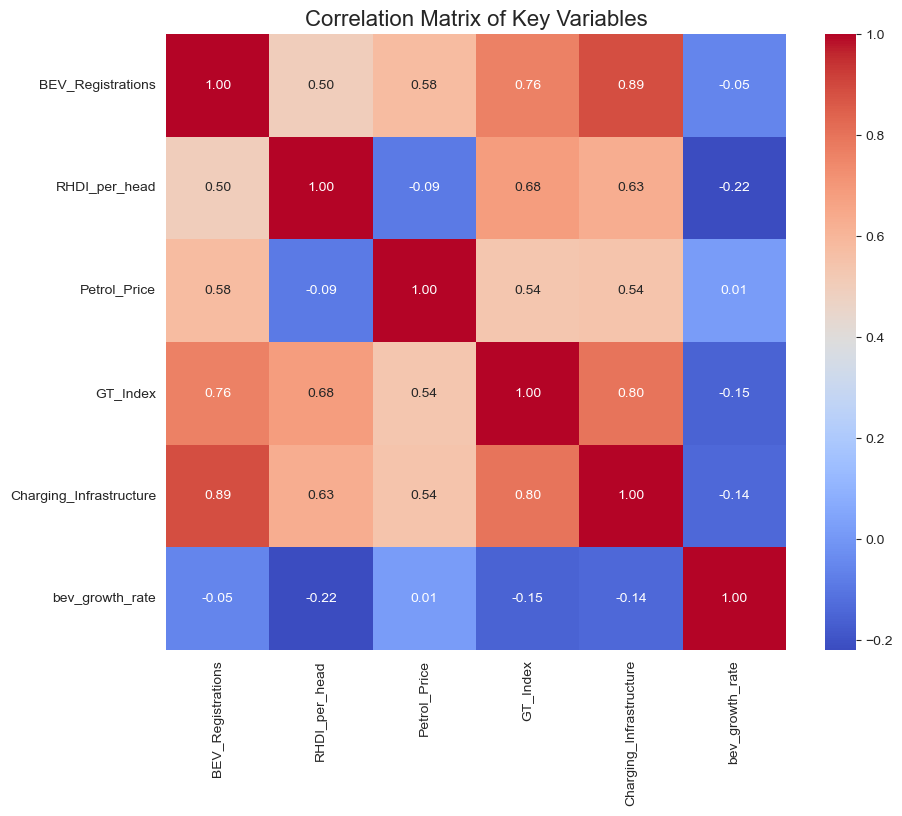

In [4]:
# Selecting a subset of key features for the correlation matrix to keep it readable
key_features = [
    'BEV_Registrations',
    'RHDI_per_head',
    'Petrol_Price',
    'GT_Index',
    'Charging_Infrastructure',
    'bev_growth_rate'
]
corr_matrix = df[key_features].corr()

# Plot the heatmap
print("\n--- Plotting Correlation Heatmap of Key Drivers ---")
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Key Variables', fontsize=16)
plt.show()

## Driver Visualizations



--- Plotting Deep-Dive Driver Analysis ---


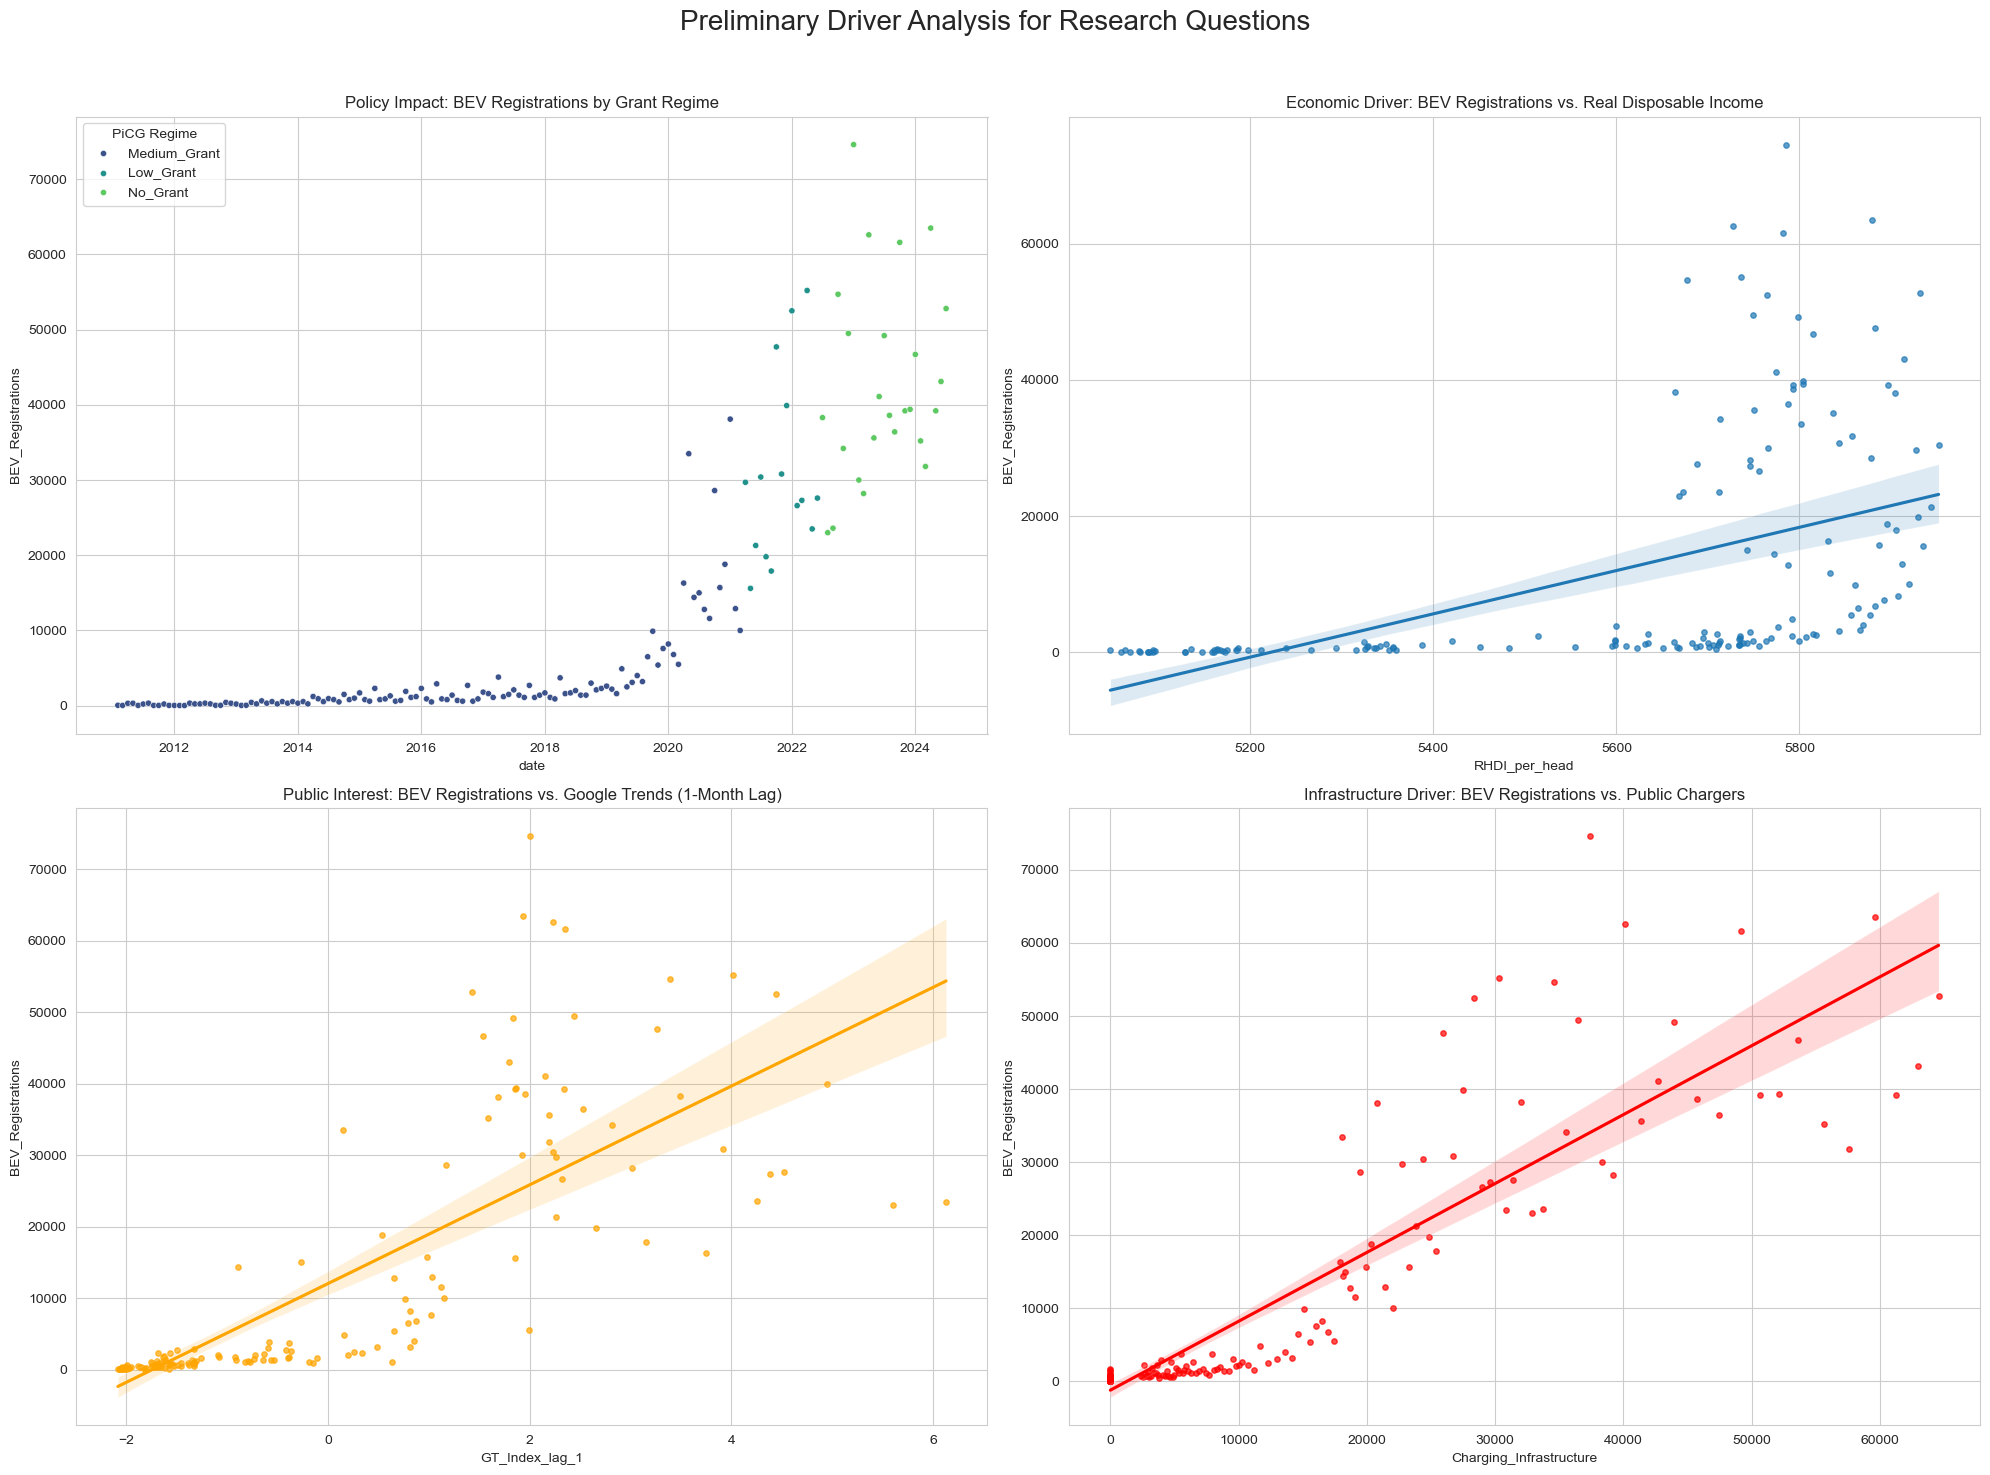

In [5]:
print("\n--- Plotting Deep-Dive Driver Analysis ---")
fig, axes = plt.subplots(2, 2, figsize=(20, 15))
fig.suptitle('Preliminary Driver Analysis for Research Questions', fontsize=20)

# RQ3: Policy Impact
sns.scatterplot(ax=axes[0, 0], data=df, x=df.index, y='BEV_Registrations', hue='policy_regime', palette='viridis', s=20)
axes[0, 0].set_title('Policy Impact: BEV Registrations by Grant Regime')
axes[0, 0].legend(title='PiCG Regime')

# RQ4: Economic Drivers
sns.regplot(ax=axes[0, 1], data=df, x='RHDI_per_head', y='BEV_Registrations', scatter_kws={'s':15, 'alpha':0.7})
axes[0, 1].set_title('Economic Driver: BEV Registrations vs. Real Disposable Income')

# RQ5: Public Interest
# We plot against a 1-month lag of Google Trends to check if it's a leading indicator
sns.regplot(ax=axes[1, 0], data=df, x='GT_Index_lag_1', y='BEV_Registrations', color='orange', scatter_kws={'s':15, 'alpha':0.7})
axes[1, 0].set_title('Public Interest: BEV Registrations vs. Google Trends (1-Month Lag)')

# RQ6: Infrastructure
sns.regplot(ax=axes[1, 1], data=df, x='Charging_Infrastructure', y='BEV_Registrations', color='red', scatter_kws={'s':15, 'alpha':0.7})
axes[1, 1].set_title('Infrastructure Driver: BEV Registrations vs. Public Chargers')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

**Policy**: The plot clearly shows that the market continued to accelerate even as the grant was reduced and removed, suggesting other factors became more dominant over time.

**Economics**: There is a clear, strong positive relationship between disposable income and BEV registrations.

**Public Interest**: The relationship between lagged Google search interest and BEV registrations is also strongly positive, suggesting it may be a useful leading indicator for forecasting.

**Infrastructure**: The relationship between charging infrastructure and adoption is extremely strong and appears to be non-linear, accelerating as more chargers become available.

## The Cross-Correlation Function (CCF) Plot

--- Generating Cross-Correlation Plots for All Key Drivers ---


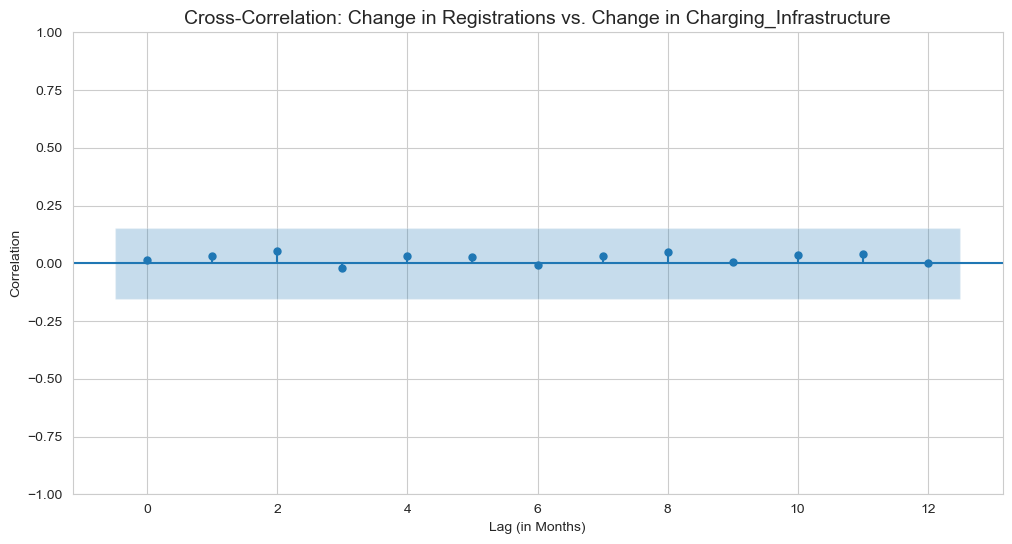

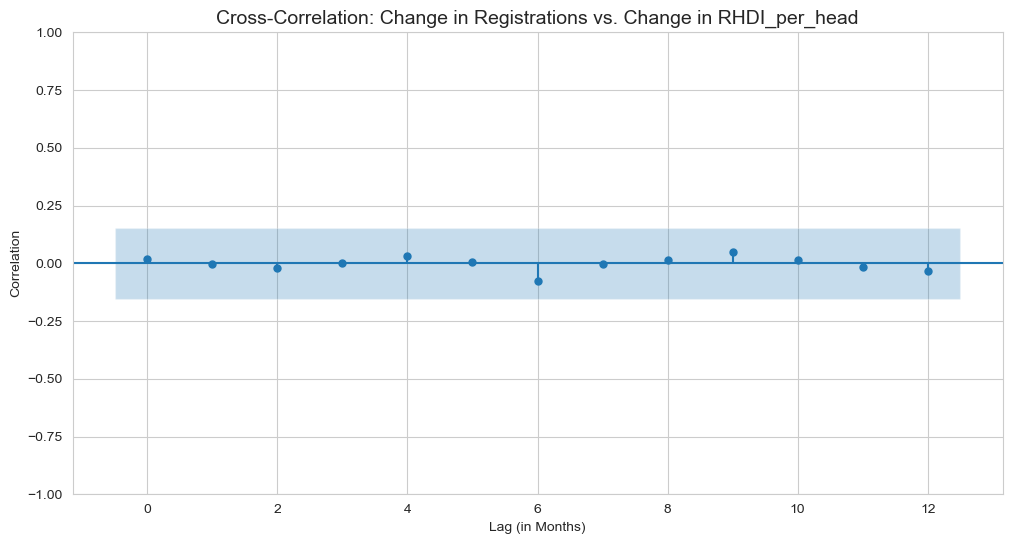

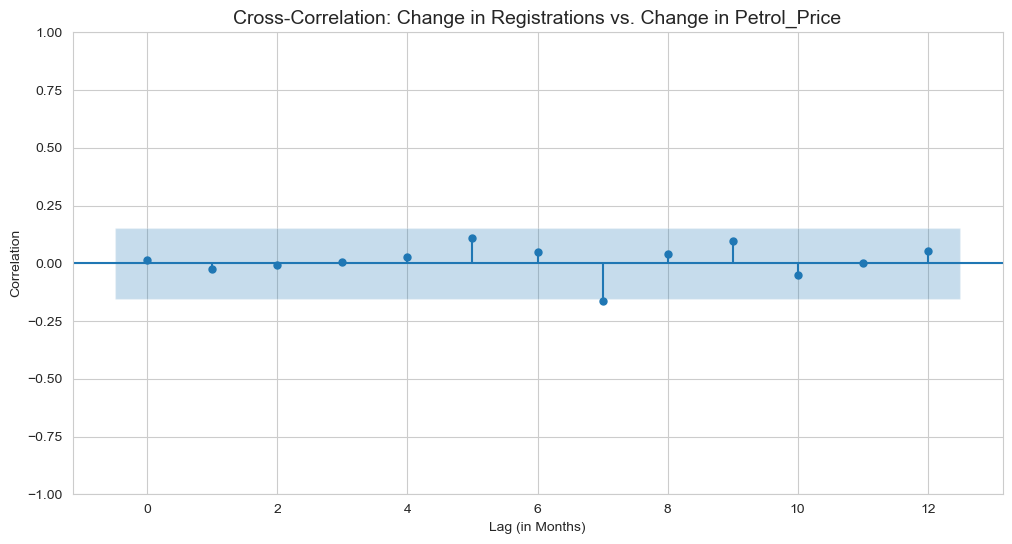

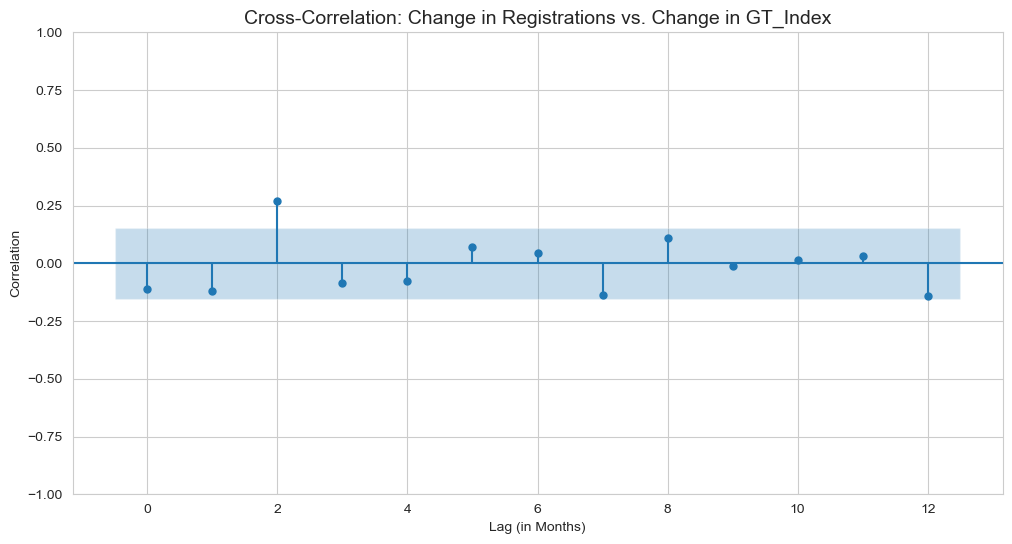

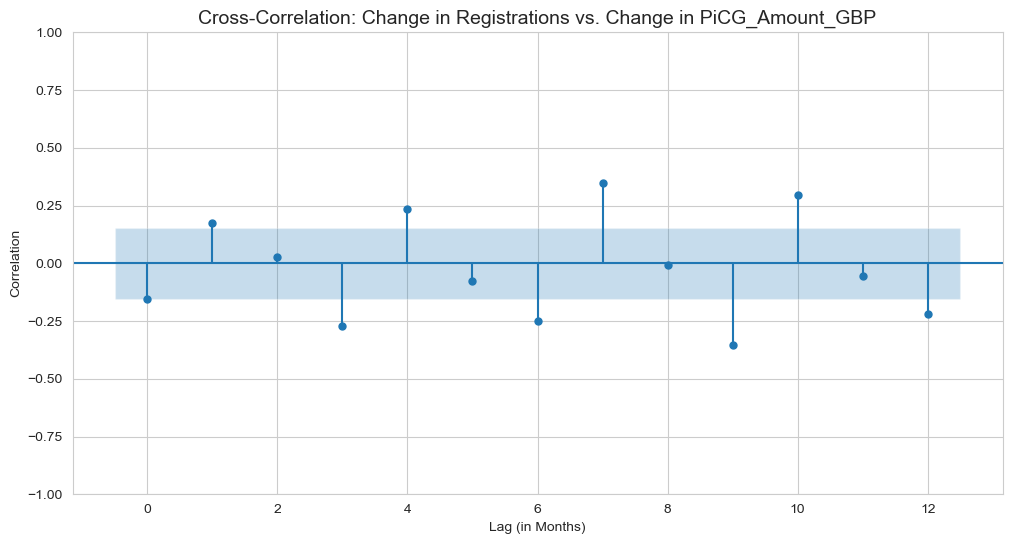

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

# Load the original dataset
df = pd.read_csv('..\\Clean Data\\Datasets\\final_dataset.csv', parse_dates=['date'], index_col='date')

# Set plot style for better aesthetics
sns.set_style("whitegrid")

# --- Step 1: Define Target and Key Drivers to Analyze ---
TARGET = 'BEV_Registrations'
DRIVERS = [
    'Charging_Infrastructure',
    'RHDI_per_head',
    'Petrol_Price',
    'GT_Index',
    'PiCG_Amount_GBP' # Included for completeness, with a caveat below
]

print("--- Generating Cross-Correlation Plots for All Key Drivers ---")

# --- Step 2: Loop Through Drivers and Generate CCF Plots ---
for driver in DRIVERS:
    # Make the series stationary by differencing and remove NaNs
    df_diff = df[[TARGET, driver]].diff().dropna()

    # Create the plot
    fig, ax = plt.subplots(figsize=(12, 6))
    sm.graphics.tsa.plot_ccf(df_diff[TARGET], df_diff[driver], ax=ax, lags=12)

    ax.set_title(f'Cross-Correlation: Change in Registrations vs. Change in {driver}', fontsize=14)
    ax.set_xlabel('Lag (in Months)')
    ax.set_ylabel('Correlation')
    plt.show()

## Granger Causality Test

In [1]:
import pandas as pd
from statsmodels.tsa.stattools import grangercausalitytests

print("--- Granger Causality Analysis ---")

# --- Step 1: Load and Prepare Data ---
df = pd.read_csv('..\\Clean Data\\Datasets\\final_dataset.csv', parse_dates=['date'], index_col='date')
TARGET = 'BEV_Registrations'
DRIVERS = ['Charging_Infrastructure', 'GT_Index', 'Petrol_Price']

# Granger causality requires stationary data, so we use the first difference
df_diff = df[[TARGET] + DRIVERS].diff().dropna()
print("Data differenced to ensure stationarity.")

# --- Step 2: Run Tests for Each Driver ---
max_lag = 4 # Test for causality up to a 4-month lag
print(f"\nRunning Granger Causality tests up to a {max_lag}-month lag...")

for driver in DRIVERS:
    print(f"\n--- Testing if '{driver}' Granger-causes '{TARGET}' ---")
    
    # The test requires a dataframe with the two series in the correct order
    test_data = df_diff[[TARGET, driver]]
    
    # Run the test and capture the output
    # The 'verbose=True' will print the detailed results for each lag
    grangercausalitytests(test_data, maxlag=max_lag, verbose=True)

--- Granger Causality Analysis ---
Data differenced to ensure stationarity.

Running Granger Causality tests up to a 4-month lag...

--- Testing if 'Charging_Infrastructure' Granger-causes 'BEV_Registrations' ---

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2293  , p=0.6327  , df_denom=157, df_num=1
ssr based chi2 test:   chi2=0.2337  , p=0.6288  , df=1
likelihood ratio test: chi2=0.2335  , p=0.6289  , df=1
parameter F test:         F=0.2293  , p=0.6327  , df_denom=157, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.0293  , p=0.3597  , df_denom=154, df_num=2
ssr based chi2 test:   chi2=2.1253  , p=0.3455  , df=2
likelihood ratio test: chi2=2.1113  , p=0.3480  , df=2
parameter F test:         F=1.0293  , p=0.3597  , df_denom=154, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.1353  , p=0.3368  , df_denom=151, df_num=3
ssr based chi2 test:   chi2=3.5639  , p=0.3126  , df=3
likelihoo

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
